0. 구글 드라이브 연동 & 기본 설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 시드 고정 (재현성)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 이미지/배치 설정
IMG_HEIGHT = 128
IMG_WIDTH  = 128
BATCH_SIZE = 32
TARGET_PER_CLASS = 500   # train에서 클래스별 목표 개수

# ★ ADASYN용 데이터셋 경로
BASE_DIR  = '/content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_ADASYN'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR  = os.path.join(BASE_DIR, 'test')

# train 내 폴더들
normal_train_dir = os.path.join(TRAIN_DIR, 'normal')
type1_train_dir  = os.path.join(TRAIN_DIR, 'type1')
type2_train_dir  = os.path.join(TRAIN_DIR, 'type2')

# ADASYN 결과 저장할 폴더
type1_adasyn_dir = os.path.join(TRAIN_DIR, 'type1(ADASYN)')
type2_adasyn_dir = os.path.join(TRAIN_DIR, 'type2(ADASYN)')

print("TRAIN_DIR :", TRAIN_DIR)
print("TEST_DIR  :", TEST_DIR)
print("normal_train_dir :", normal_train_dir)
print("type1_train_dir  :", type1_train_dir)
print("type2_train_dir  :", type2_train_dir)
print("type1_adasyn_dir :", type1_adasyn_dir)
print("type2_adasyn_dir :", type2_adasyn_dir)

Mounted at /content/drive
TRAIN_DIR : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_ADASYN/train
TEST_DIR  : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_ADASYN/test
normal_train_dir : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_ADASYN/train/normal
type1_train_dir  : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_ADASYN/train/type1
type2_train_dir  : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_ADASYN/train/type2
type1_adasyn_dir : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_ADASYN/train/type1(ADASYN)
type2_adasyn_dir : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_ADASYN/train/type2(ADASYN)


1.  기존 데이터셋 정보 확인

In [2]:
def get_image_paths(folder):
    if not os.path.exists(folder):
        return []
    paths = []
    for name in os.listdir(folder):
        p = os.path.join(folder, name)
        if not os.path.isfile(p):
            continue
        try:
            with Image.open(p) as im:
                im.verify()
            paths.append(p)
        except Exception:
            # 이미지가 아니면 무시
            pass
    return sorted(paths)

normal_paths_orig = get_image_paths(normal_train_dir)
type1_paths_orig  = get_image_paths(type1_train_dir)
type2_paths_orig  = get_image_paths(type2_train_dir)

print("=== 기존 train 데이터셋(증강 전) ===")
print("normal 개수:", len(normal_paths_orig))
print("type1  개수:", len(type1_paths_orig))
print("type2  개수:", len(type2_paths_orig))

=== 기존 train 데이터셋(증강 전) ===
normal 개수: 500
type1  개수: 25
type2  개수: 25


2. ADASYN으로 type1, tyoe2 각각 475장 생성

In [3]:
# 2-1. ADASYN 함수 정의
def load_images(paths, img_size=(IMG_WIDTH, IMG_HEIGHT)):
    """경로 리스트에서 이미지를 로드해서 [0,1] float32 배열로 반환."""
    imgs = []
    for p in paths:
        img = Image.open(p).convert("RGB")
        img = img.resize(img_size)
        img = np.array(img, dtype=np.float32) / 255.0
        imgs.append(img)
    return np.stack(imgs, axis=0)  # (N, H, W, C)


def adasyn_augment(X_min, X_maj, n_new, k=5):
    """
    ADASYN 구현 (간단 버전).

    X_min : (N_min, d) minority 클래스 벡터들 (예: type1 혹은 type2)
    X_maj : (N_maj, d) majority 클래스 벡터들 (예: normal)
    n_new : 생성할 synthetic 샘플 수
    k     : 최근접 이웃 개수 (불균형 정도 r_i 계산용)

    핵심 아이디어:
    - minority 샘플마다 주변 majority 비율 r_i 계산
    - r_i가 큰(=분류가 어려운) 샘플일수록 더 많은 synthetic 샘플을 생성
    - 생성은 SMOTE처럼 minority 이웃 사이 선형 보간으로 생성
    """
    if n_new <= 0 or X_min.shape[0] < 2:
        return np.empty((0, X_min.shape[1]), dtype=X_min.dtype)

    n_min = X_min.shape[0]
    # 전체 데이터 구성
    X_all = np.vstack([X_min, X_maj])
    y_all = np.concatenate([
        np.ones(n_min, dtype=int),            # minority = 1
        np.zeros(X_maj.shape[0], dtype=int)   # majority = 0
    ])

    # 각 minority 샘플에 대해 k-NN 탐색
    k_nn = min(k + 1, X_all.shape[0])  # 자기 자신 포함이므로 +1
    nbrs = NearestNeighbors(n_neighbors=k_nn)
    nbrs.fit(X_all)
    neighbors = nbrs.kneighbors(X_min, return_distance=False)  # (n_min, k+1)

    # 1) 각 minority 샘플의 "주변 majority 비율" r_i 계산
    r = np.zeros(n_min, dtype=float)
    for i in range(n_min):
        nn_idx = neighbors[i][1:]  # 자기 자신 제외
        nn_labels = y_all[nn_idx]
        n_maj_neighbors = np.sum(nn_labels == 0)
        r[i] = n_maj_neighbors / float(k)  # k개 이웃 중 majority 비율

    # r 합이 0이면(주위에 majority가 거의 없으면) 균일 분배 (사실상 일반 SMOTE)
    r_sum = np.sum(r)
    if r_sum == 0:
        print("[주의] ADASYN: 모든 r_i가 0이라 균일하게 샘플을 생성합니다 (SMOTE 유사 동작).")
        p = np.ones_like(r) / n_min
    else:
        p = r / r_sum  # 샘플별 비율

    # 각 샘플마다 생성할 개수 g_i
    g = np.round(p * n_new).astype(int)

    # rounding으로 인한 합 차이 보정
    diff = n_new - np.sum(g)
    if diff > 0:
        # diff개 만큼 r_i가 큰 순으로 +1
        idx_sorted = np.argsort(-r)
        for idx in idx_sorted[:diff]:
            g[idx] += 1
    elif diff < 0:
        # diff가 음수면 r_i가 작은 순으로 -1
        idx_sorted = np.argsort(r)
        for idx in idx_sorted[:(-diff)]:
            if g[idx] > 0:
                g[idx] -= 1

    assert np.sum(g) == n_new, "ADASYN 내부 에러: g_i 합이 n_new와 다릅니다."

    # 2) synthetic 샘플 생성 (각 샘플별 g_i개씩)
    synthetic = []
    for i in range(n_min):
        if g[i] == 0:
            continue

        nn_idx = neighbors[i][1:]  # 전체 데이터에서의 이웃 index
        # minority 이웃만 골라서 사용 (y_all == 1 && index < n_min)
        nn_minority = [j for j in nn_idx if (y_all[j] == 1 and j < n_min)]

        for _ in range(g[i]):
            if len(nn_minority) > 0:
                j_global = random.choice(nn_minority)
                j = j_global
            else:
                # minority 이웃 없으면 전체 minority 중에서 랜덤
                j = random.randint(0, n_min - 1)

            lam = random.random()
            new_sample = X_min[i] + lam * (X_min[j] - X_min[i])
            synthetic.append(new_sample)

    if len(synthetic) == 0:
        return np.empty((0, X_min.shape[1]), dtype=X_min.dtype)
    return np.stack(synthetic, axis=0)


def save_synthetic_images(synthetic_imgs, target_dir, prefix):
    """
    synthetic_imgs: float32, [0,1], shape = (N, H, W, 3)
    target_dir    : 저장할 폴더 (예: type1(ADASYN) 폴더)
    prefix        : 파일 이름 접두사 (예: 'adasyn_type1')
    """
    os.makedirs(target_dir, exist_ok=True)
    # 이미 prefix로 시작하는 파일이 있다면, 그 뒤 번호부터 이어서 저장
    existing = get_image_paths(target_dir)
    existing_prefix_count = sum(
        1 for p in existing if os.path.basename(p).startswith(prefix)
    )
    start_idx = existing_prefix_count

    for i, img in enumerate(synthetic_imgs):
        img_uint8 = (img * 255).astype(np.uint8)
        im = Image.fromarray(img_uint8)
        filename = f"{prefix}_{start_idx + i:05d}.png"
        im.save(os.path.join(target_dir, filename))


def augment_class_with_adasyn(orig_dir, adasyn_dir, prefix,
                              normal_paths, target_total=TARGET_PER_CLASS):
    """
    orig_dir    : minority 원본 이미지 폴더 (type1, type2)
    adasyn_dir  : ADASYN으로 생성한 이미지 저장 폴더 (type1(ADASYN), type2(ADASYN))
    prefix      : 생성 이미지 파일 이름 접두사 (예: 'adasyn_type1')
    normal_paths: majority 클래스(normal)의 이미지 경로 리스트
    target_total: orig + ADASYN 합쳐서 사용하고 싶은 총 개수

    - orig_dir + adasyn_dir 안의 이미지 개수를 보고
      이미 target_total 이상이면 아무 것도 안 함 (여러 번 실행해도 안전).
    - ADASYN 기반으로 사용할 minority는 orig_dir 안의 이미지들만 사용.
    - majority는 normal_paths 중 일부(예: 최대 500장)만 사용.
    """
    orig_paths    = get_image_paths(orig_dir)
    adasyn_paths  = get_image_paths(adasyn_dir)

    total_now = len(orig_paths) + len(adasyn_paths)
    print(f"\n[{orig_dir}] 현재 orig: {len(orig_paths)}, ADASYN: {len(adasyn_paths)}, 합계: {total_now}")

    if total_now >= target_total:
        print("이미 target_total 이상이므로 ADASYN 생성 생략")
        return

    if len(orig_paths) < 2:
        raise ValueError("ADASYN을 위해서는 최소 2장 이상의 minority 원본 이미지가 필요합니다.")

    if len(normal_paths) == 0:
        raise ValueError("majority 클래스(normal) 이미지가 없습니다. ADASYN을 적용할 수 없습니다.")

    # majority(normal)에서 사용할 샘플 수 제한 (메모리 보호용)
    max_maj = min(500, len(normal_paths))
    normal_sample_paths = random.sample(normal_paths, max_maj)

    to_create = target_total - total_now
    print("생성할 ADASYN 개수:", to_create)
    print("majority(normal) 샘플 사용 개수:", len(normal_sample_paths))

    # minority, majority 이미지 로드
    imgs_min = load_images(orig_paths)
    imgs_maj = load_images(normal_sample_paths)

    X_min = imgs_min.reshape(imgs_min.shape[0], -1)
    X_maj = imgs_maj.reshape(imgs_maj.shape[0], -1)

    synthetic_flat = adasyn_augment(X_min, X_maj, n_new=to_create, k=5)
    synthetic = synthetic_flat.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)
    synthetic = np.clip(synthetic, 0.0, 1.0)

    save_synthetic_images(synthetic, adasyn_dir, prefix)

    # 최종 개수 확인
    adasyn_paths_after = get_image_paths(adasyn_dir)
    total_after = len(orig_paths) + len(adasyn_paths_after)
    print("ADASYN 저장 후 ADASYN 개수:", len(adasyn_paths_after))
    print("증강 이후 총 개수 (orig + ADASYN):", total_after)

In [4]:
# 2-2. ADASYN 적용
augment_class_with_adasyn(
    orig_dir=type1_train_dir,
    adasyn_dir=type1_adasyn_dir,
    prefix="adasyn_type1",
    normal_paths=normal_paths_orig,
    target_total=TARGET_PER_CLASS
)

augment_class_with_adasyn(
    orig_dir=type2_train_dir,
    adasyn_dir=type2_adasyn_dir,
    prefix="adasyn_type2",
    normal_paths=normal_paths_orig,
    target_total=TARGET_PER_CLASS
)

# 증강 결과 확인
type1_orig_paths    = get_image_paths(type1_train_dir)
type1_adasyn_paths  = get_image_paths(type1_adasyn_dir)
type2_orig_paths    = get_image_paths(type2_train_dir)
type2_adasyn_paths  = get_image_paths(type2_adasyn_dir)

print("\n=== 증강 이후 train 데이터 구조 확인 (ADASYN) ===")
print("type1 원본 개수:", len(type1_orig_paths))
print("type1 ADASYN 개수:", len(type1_adasyn_paths))
print("type1 합계:", len(type1_orig_paths) + len(type1_adasyn_paths))

print("\ntype2 원본 개수:", len(type2_orig_paths))
print("type2 ADASYN 개수:", len(type2_adasyn_paths))
print("type2 합계:", len(type2_orig_paths) + len(type2_adasyn_paths))


[/content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_ADASYN/train/type1] 현재 orig: 25, ADASYN: 0, 합계: 25
생성할 ADASYN 개수: 475
majority(normal) 샘플 사용 개수: 500
ADASYN 저장 후 ADASYN 개수: 475
증강 이후 총 개수 (orig + ADASYN): 500

[/content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_ADASYN/train/type2] 현재 orig: 25, ADASYN: 0, 합계: 25
생성할 ADASYN 개수: 475
majority(normal) 샘플 사용 개수: 500
ADASYN 저장 후 ADASYN 개수: 475
증강 이후 총 개수 (orig + ADASYN): 500

=== 증강 이후 train 데이터 구조 확인 (ADASYN) ===
type1 원본 개수: 25
type1 ADASYN 개수: 475
type1 합계: 500

type2 원본 개수: 25
type2 ADASYN 개수: 475
type2 합계: 500


3. 새로 생성된 이미지 예시 확인 (랜덤 10장)

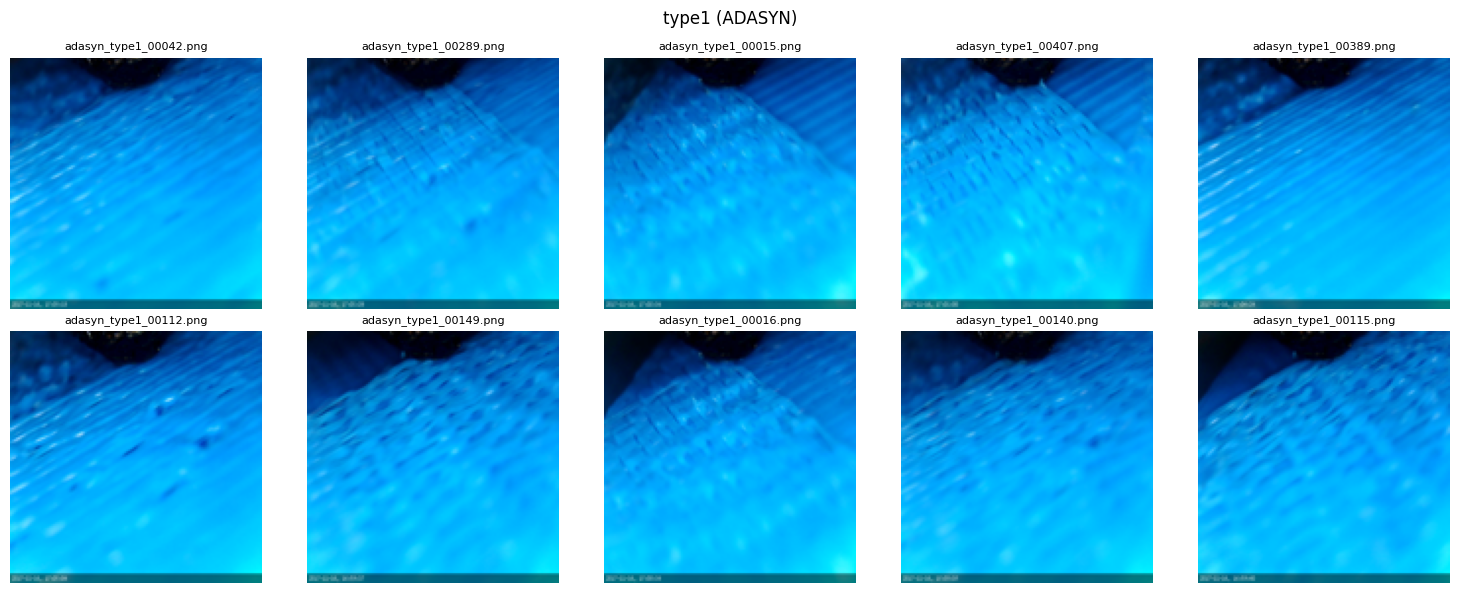

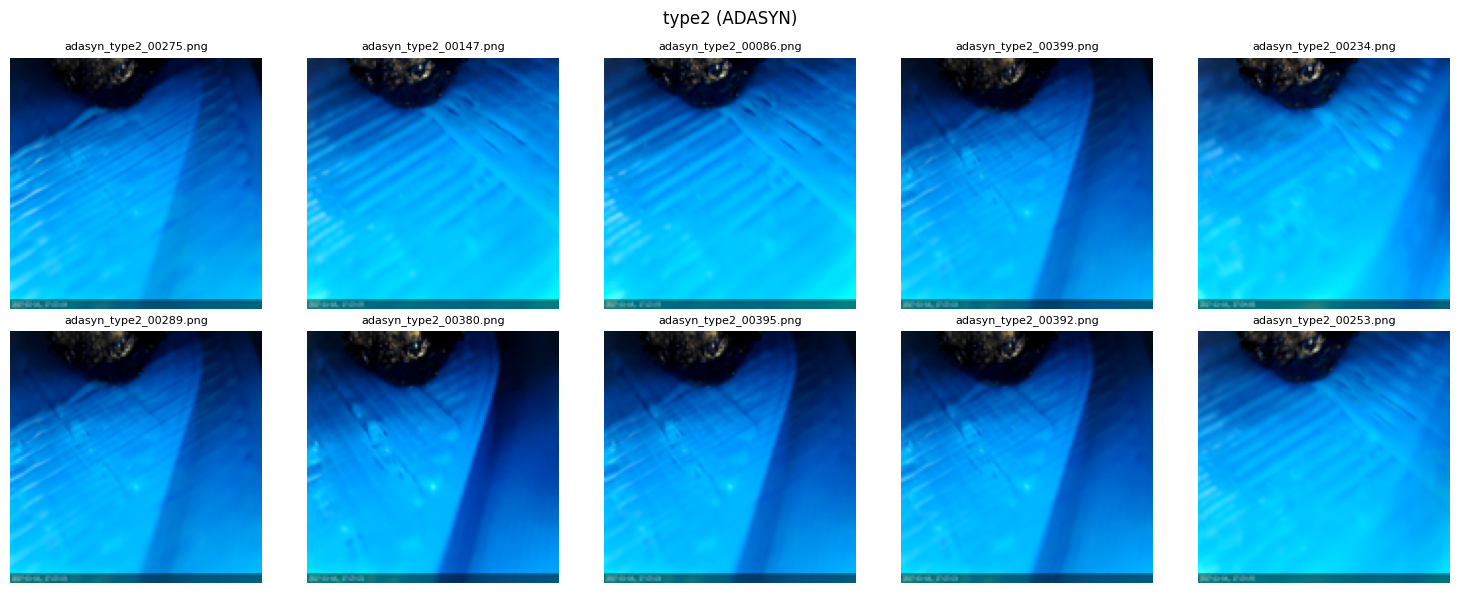

In [5]:
def show_random_images(paths, n=10, title=""):
    sample_paths = random.sample(paths, min(n, len(paths)))
    n_cols = 5
    n_rows = int(np.ceil(len(sample_paths) / n_cols))

    plt.figure(figsize=(n_cols*3, n_rows*3))
    for idx, p in enumerate(sample_paths):
        img = Image.open(p).convert("RGB")
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        plt.subplot(n_rows, n_cols, idx+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(p), fontsize=8)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_random_images(type1_adasyn_paths, n=10, title="type1 (ADASYN)")
show_random_images(type2_adasyn_paths, n=10, title="type2 (ADASYN)")

4. 새로운 데이터셋 (총 1500장) CNN 학습

In [6]:
# 4-1. 학습에 쓸 경로 / 라벨 구성
CLASS_NAMES = ['normal', 'type1', 'type2']
label_to_index = {name: idx for idx, name in enumerate(CLASS_NAMES)}
print("label_to_index:", label_to_index)

def sample_paths_for_class(base_paths, adasyn_paths=None, max_count=TARGET_PER_CLASS):
    """
    base_paths   : 원본 이미지 경로 리스트
    adasyn_paths : ADASYN 이미지 경로 리스트 (없으면 None)
    max_count    : 이 클래스에서 최종 사용할 이미지 수
    """
    all_paths = list(base_paths)
    if adasyn_paths is not None:
        all_paths.extend(adasyn_paths)

    if len(all_paths) < max_count:
        print(f"[경고] 이 클래스에 이미지가 {len(all_paths)}장뿐이라 {max_count}장까지 못 채웁니다.")
        return all_paths
    elif len(all_paths) > max_count:
        return random.sample(all_paths, max_count)
    else:
        return all_paths

# normal은 ADASYN 안 했다고 가정
normal_paths_for_train = sample_paths_for_class(
    base_paths=normal_paths_orig,
    adasyn_paths=None,
    max_count=TARGET_PER_CLASS
)

type1_paths_for_train = sample_paths_for_class(
    base_paths=type1_orig_paths,
    adasyn_paths=type1_adasyn_paths,
    max_count=TARGET_PER_CLASS
)

type2_paths_for_train = sample_paths_for_class(
    base_paths=type2_orig_paths,
    adasyn_paths=type2_adasyn_paths,
    max_count=TARGET_PER_CLASS
)

print("\n=== 학습에 실제로 사용할 개수 ===")
print("normal:", len(normal_paths_for_train))
print("type1 :", len(type1_paths_for_train))
print("type2 :", len(type2_paths_for_train))

# 전체 train 리스트 + 라벨 만들기
train_paths = (
    normal_paths_for_train +
    type1_paths_for_train +
    type2_paths_for_train
)
train_labels = (
    [label_to_index['normal']] * len(normal_paths_for_train) +
    [label_to_index['type1']]  * len(type1_paths_for_train) +
    [label_to_index['type2']]  * len(type2_paths_for_train)
)

# 섞기
combined = list(zip(train_paths, train_labels))
random.shuffle(combined)
train_paths, train_labels = zip(*combined)
train_paths  = list(train_paths)
train_labels = list(train_labels)

print("\n총 train 샘플 수:", len(train_paths))  # 이상적으로 1500

label_to_index: {'normal': 0, 'type1': 1, 'type2': 2}

=== 학습에 실제로 사용할 개수 ===
normal: 500
type1 : 500
type2 : 500

총 train 샘플 수: 1500


In [7]:
# 4-2. tf.data 파이프라인 생성
AUTOTUNE = tf.data.AUTOTUNE

def process_path(path, label):
    # 파일 읽기
    img_bytes = tf.io.read_file(path)

    # 이미지 디코딩 (jpg/png 등 자동 인식)
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])  # (H, W, C)

    # 크기 변경
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

    # [0,255] → [0,1]
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 데이터 증강
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ]
)

def augment(image, label):
    return data_augmentation(image, training=True), label

train_ds = train_ds.shuffle(buffer_size=len(train_paths), seed=SEED)
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [8]:
# 4-3. CNN 모델 정의 & 학습
num_classes = len(CLASS_NAMES)

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation="relu")(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

EPOCHS = 15
history = model.fit(
    train_ds,
    epochs=EPOCHS
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,803 (24.86 MB)

 Trainable params: 6,516,803 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.4997 - loss: 31.2396
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.7411 - loss: 0.4886
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7768 - loss: 0.4281
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8281 - loss: 0.3602
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8492 - loss: 0.3697
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8708 - loss: 0.3311
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8025 - loss: 0.8985
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8334 - loss: 0.3924
Epoch 9/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8826 - loss: 0.3309
Epoch 10/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9125 - loss: 0.2283
Epoch 11/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9322 - loss: 0.1861
Epoch 12/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9072 - 

5. test 데이터로 성능 확인

In [9]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,          # normal, type1, type2 순서를 train과 맞춤
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = test_ds.map(
    lambda x, y: (tf.image.convert_image_dtype(x, tf.float32), y),
    num_parallel_calls=AUTOTUNE
)
test_ds = test_ds.prefetch(AUTOTUNE)

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

Found 300 files belonging to 3 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 461ms/step
y_true shape: (300,)
y_pred shape: (300,)


6. macro F-score, precision, recall

In [10]:
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro'
)

print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall   : {recall_macro:.4f}")
print(f"Macro F1-score : {f1_macro:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

Macro Precision: 0.4651
Macro Recall   : 0.4900
Macro F1-score : 0.4020

=== Classification Report ===
              precision    recall  f1-score   support

      normal       0.40      1.00      0.57       100
       type1       0.00      0.00      0.00       100
       type2       1.00      0.47      0.64       100

    accuracy                           0.49       300
   macro avg       0.47      0.49      0.40       300
weighted avg       0.47      0.49      0.40       300



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

7. Confusion Matrix

Confusion Matrix:
 [[100   0   0]
 [100   0   0]
 [ 53   0  47]]


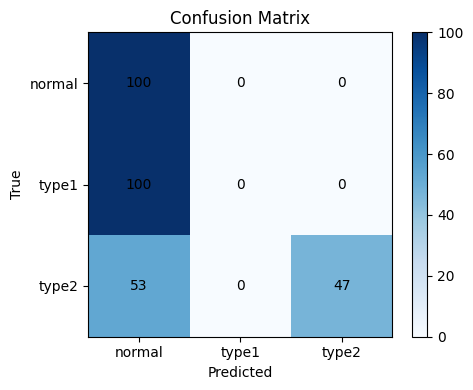

In [11]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, cmap='Blues')

ax.set_xticks(np.arange(len(CLASS_NAMES)))
ax.set_yticks(np.arange(len(CLASS_NAMES)))
ax.set_xticklabels(CLASS_NAMES)
ax.set_yticklabels(CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center", color="black")

plt.title("Confusion Matrix")
plt.colorbar(im)
plt.tight_layout()
plt.show()